# Importance sampling

## Recap

We have some target function (the likelihood times the prior) in some parameter space, and we want to integrate it. The target function may be in a odd shape, such as a banana.

![banana](img/banana.png)

As a toy example, we chose the following likelihood:

In [13]:
import numpy as np

def loglikelihood(*parameters):
    a = np.asarray(parameters)[:-1] * 10
    b = np.asarray(parameters)[1:] * 10
    return -2 * (100 * (b - a**2)**2 + (1 - a)**2).sum()

And we assume our prior is uniform in the domain -1/2 to +1/2 in each parameter. 
We use two parameters at the moment.

Like so:

In [14]:
print(loglikelihood(1, 1))
print(loglikelihood(*[0.5, 0.5]))

-1620162
-80032.0


In [15]:
lo = -0.5
hi = 0.5
dim = 2

Lets plot this function in 2d:

In [17]:
import matplotlib.pyplot as plt

a = np.linspace(lo, hi, 400)
b = np.linspace(lo, hi, 400)

# TODO by you! (meshgrid and plt.imshow can be helpful)



## Importance sampling motivation

Instead of a uniform spaced deterministic grid, lets now use uniformly distributed *random* points:

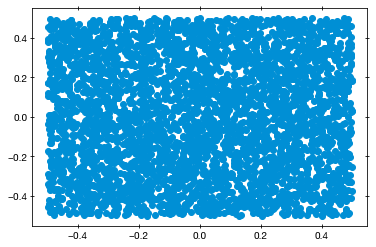

In [18]:
Ndraw = 4000

proposed_samples = np.random.uniform(lo, hi, size=(Ndraw, dim))

plt.scatter(proposed_samples[:,0], proposed_samples[:,1]);

If we evaluate the likelihood at each point:

In [19]:
proposed_samples_loglike = [loglikelihood(*sample) for sample in proposed_samples]

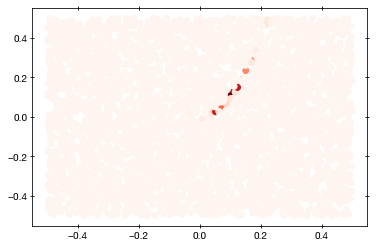

In [20]:
plt.scatter(proposed_samples[:,0], proposed_samples[:,1], c=np.exp(proposed_samples_loglike), cmap='Reds');

Monte Carlo integration tells us that

$Z=\int d\theta f(\theta) \approx \frac{1}{N} \sum_{i=1}^N f(\theta_i) $

The agreement is exact when $N\rightarrow \infty$.

In [36]:
weights = np.exp(proposed_samples_loglike)

Z = weights.mean()

Z

0.0015598944013746816

## Effective number of samples

Since most samples have zero weight, they do not contribute effectively to the integral.

We can compute the effective number of samples can be defined as:

$ESS = \frac{N}{1 + \frac{1}{N}\sum_i\left(N \times \frac{w_i}{\sum_i w_i} - 1\right)}$


In [37]:
def effective_sample_size(weights):
    return int(len(weights) / (1 + (weights / weights.mean() - 1)**2).mean() )

'Effective number of samples: %d' % effective_sample_size(weights)

'Effective number of samples: 13'

## Exercise 1 (20 points)

1a) Measure the variance in the integral estimate by running the method a few times.

1b) Vary the number of samples drawn. Plot variance vs number of samples.

1c) Compare to the variance expected: $Var(Z)=Var(f) / N_{draw}$



# Importance Sampling


* Most of the points had zero likelihood.

* To better use the evaluations, perhaps we can choose spacing that is biased to the likelihood peak?

To illustrate, instead of the flat proposal (top), maybe we could change the method to sample more points where the likelihood is high (bottom)?

![importance sampling](img/Importance-Sampling.png)

Lets try a narrow Gaussian centered at (0.1, 0.1):

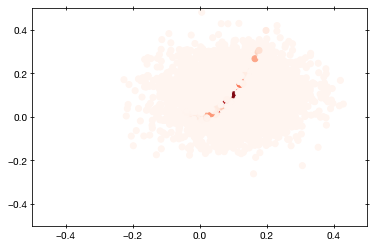

In [43]:
ctr = 0.1 + np.zeros(dim)
std = 0.1 + np.zeros(dim)

biased_proposed_samples = np.random.normal(ctr, std, size=(Ndraw, dim))
biased_proposed_samples_loglike = [loglikelihood(*sample) for sample in biased_proposed_samples]

plt.scatter(biased_proposed_samples[:,0], biased_proposed_samples[:,1], c=np.exp(biased_proposed_samples_loglike), cmap='Reds');
plt.xlim(lo, hi)
plt.ylim(lo, hi);

It looks like we are getting many more "hits" on high probability regions now.

But our proposal is biased. The bias is the probability density of our proposal function:

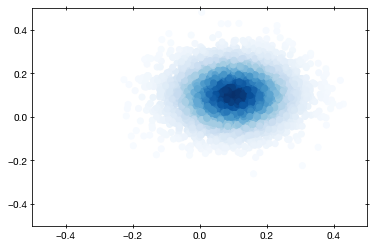

In [44]:
import scipy.stats

random_variable = scipy.stats.norm(ctr, std)
importance = [np.product(random_variable.pdf(biased_proposed_sample)) for biased_proposed_sample in biased_proposed_samples]

plt.scatter(biased_proposed_samples[:,0], biased_proposed_samples[:,1], c=importance, cmap='Blues');
plt.xlim(lo, hi)
plt.ylim(lo, hi);

Importance weighting is adjusting the weights in our sum from

$Z\approx \frac{1}{N} \sum_{i=1}^N f(\theta_i) $

to

$Z\approx \frac{1}{N} \sum_{i=1}^N f(\theta_i)/I(\theta_i) $

In words, we down-weight samples where the proposal had high probability.

In [45]:
weights = np.exp(biased_proposed_samples_loglike) / importance

Z = weights.mean()

Z

0.0018726226854311238

# Effective sample size

In [46]:
effective_sample_size(weights)

85

# Posterior probability distributions

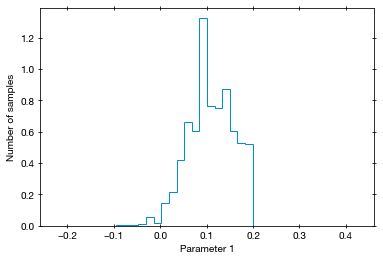

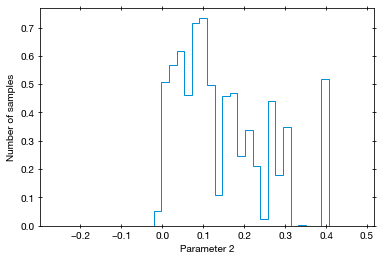

In [50]:
for i in range(dim):
    plt.figure()
    plt.xlabel("Parameter %d" % (i+1))
    plt.ylabel("Number of samples")
    plt.hist(biased_proposed_samples[:,i], weights=weights, bins=40, histtype='step')


## Unweighted posterior samples

In [51]:
# pick as many as there are effective samples
N_chosen = effective_sample_size(weights)
# pick them proportional to their weight
indices_chosen = np.random.choice(len(weights), p=weights / weights.sum(), size=N_chosen)
unweighted_posterior_samples = biased_proposed_samples[indices_chosen,:]

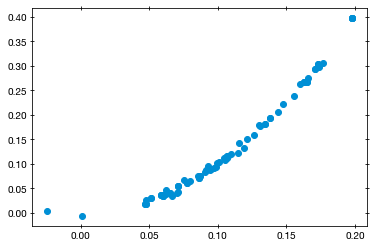

In [52]:
plt.scatter(unweighted_posterior_samples[:,0], unweighted_posterior_samples[:,1]);

## Questions:

(5 points for contibuting something to the discussion)

* What would be the ideal proposal?

* If the proposal matched the target probability density, all sum terms would be a constant. What is that constant?

* We can already evaluate the target function, why can we not use it as a proposal?

## Quality of importance sampling

The variance of the Monte Carlo estimator of $Z$ is driven by the variance in the sum terms. Here for importance sampling:

$Var(Z)=Var(f / W) / N_{draw}$

The variance is smallest when $W \propto f$. 

We can quantify this by the variance in the sampled points:

In [30]:
'Standard deviation on Z for Uniform sampling: %.5f' % np.std(np.exp(proposed_samples_loglike))

'Standard deviation on Z for Uniform sampling: 0.02718'

In [53]:
'Standard deviation on Z for Importance sampling: %.5f' % np.std(np.exp(biased_proposed_samples_loglike) / importance)

'Standard deviation on Z for Importance sampling: 0.01270'

## Questions

* Which method is better?

* Is the variance part of the effective size samples formula?

## Exercise 2 (5 points)

Find a 90% credible region from the importance sampling results. 

Hint: use the weighted posterior samples, respecting the weighting, or the resampled posterior points.

## Exercise 3 (10 points)

Repeat exercise 1 with importance sampling.

## Homework Exercise 1 (60 points)

Optimize the Gaussian proposal.

## Homework Exercise 2 (120 points)

Vary the dimensionality of the problem. How does the variance scale with dimension?

## Further reading

Keywords:

* *Gaussian mixture models*: Useful for approximating complex target distributions
* *Variational Bayes*: A procedure for optimizing proposals
